<a href="https://colab.research.google.com/github/TokushigeJunya/ForcedHNN/blob/main/Oscillator_exp12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import autograd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

def hamiltonian_fn(coords):   #coords = [q, p]
    q, p = np.split(coords,2)
    one = np.ones_like(q)
    H = 0.5*(q**2) + 0.5*(p**2)   #hamiltonian
    return H

def dynamics_fn(t,coords):
    q = torch.tensor([coords[0].item()], requires_grad=True, dtype=torch.float32)
    p = torch.tensor([coords[1].item()], requires_grad=True, dtype=torch.float32)
    one = torch.ones_like(q, requires_grad=True, dtype=torch.float32)
    H = 0.5*(q**2) + 0.5*(p**2)   #hamiltonian
    dHdq = torch.autograd.grad(H, q, create_graph=True)[0].detach().numpy().reshape(-1)
    dHdp = torch.autograd.grad(H, p, create_graph=True)[0].detach().numpy().reshape(-1)
    S = np.concatenate([dHdp, -dHdq], axis=-1)
    return S

def dynamics_fn_ext(t, coords):
    q = torch.tensor([coords[0].item()], requires_grad=True, dtype=torch.float32)
    p = torch.tensor([coords[1].item()], requires_grad=True, dtype=torch.float32)
    one = torch.ones_like(q, requires_grad=True, dtype=torch.float32)
    H = 0.5*(q**2) + 0.5*(p**2)   #hamiltonian
    dHdq = torch.autograd.grad(H, q, create_graph=True)[0].detach().numpy().reshape(-1)
    dHdp = torch.autograd.grad(H, p, create_graph=True)[0].detach().numpy().reshape(-1)
    S = np.concatenate([dHdp, -dHdq - np.array([0.005*coords[1]])], axis=-1)
    return S

def ext_f(coords):
    q, p = np.split(coords,2)
    f = -0.005*p
    return f

def get_trajectory(t_span=[0,3], timescale=10, radius=None, y0=None, noise_std=0.05, ext=False):   #ノイズの大きさを変えたいときは、noise_stdを変える
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))

    # get initial state
    if y0 is None:
        y0 = np.random.rand(2)*2 - 1
    if radius is None:
        radius = np.random.rand()*0.9 + 0.1 # sample a range of radii
    y0 = y0 / np.sqrt((y0**2).sum()) * radius # set the appropriate radius

    if ext:
        spring_ivp = solve_ivp(fun=dynamics_fn_ext, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10)
    else:
        spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10)

    q, p = spring_ivp['y'][0], spring_ivp['y'][1]

    if ext:
        dydt = [dynamics_fn_ext(None, y) for y in spring_ivp['y'].T]
    else:
        dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]

    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)

    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

def get_dataset(samples=50, test_split=0.5, ext=False, noise_std=0.05):   #ノイズの大きさを変えたいときは、noise_stdを変える
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(0)
    torch.manual_seed(0)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(ext=ext,noise_std=noise_std)
        xs.append( np.stack([x, y]).T )
        dxs.append( np.stack([dx, dy]).T )

    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [2]:
class MLP(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = torch.nn.Linear(hidden_dim, output_dim, bias=None)

        for l in [self.linear1, self.linear2, self.linear3]:
            torch.nn.init.orthogonal_(l.weight) # use a principled initialization

        self.nonlinearity = torch.tanh

    def forward(self, x):
        h = self.nonlinearity( self.linear1(x) )
        h = self.nonlinearity( self.linear2(h) )
        return self.linear3(h)

class HNN(torch.nn.Module):
    '''Learn arbitrary vector fields that are sums of conservative and solenoidal fields'''
    def __init__(self, input_dim, differentiable_model, baseline=False):
        super(HNN, self).__init__()
        self.baseline = baseline
        self.differentiable_model = differentiable_model
        self.M = self.permutation_tensor(input_dim)

    def forward(self, x):
        # traditional forward pass
        return self.differentiable_model(x)

    def derivative(self, x, t=None):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F = self.forward(x) # traditional forward pass
        dF = torch.autograd.grad(F.sum(), x, create_graph=True)[0]

        return dF @ self.M.t()

    def permutation_tensor(self,n):
        M = torch.eye(n)
        M = torch.cat([M[n//2:], -M[:n//2]])
        return M

class Forced_HNN(torch.nn.Module):
    '''Learn arbitrary vector fields that are sums of conservative and solenoidal fields'''
    def __init__(self, input_dim, ext_model, hnn_model, baseline=False):
        super(Forced_HNN, self).__init__()
        self.baseline = baseline
        self.ext_model = ext_model
        self.hnn_model = hnn_model
        self.M = self.permutation_tensor(input_dim)

    def forward(self, x):
        # traditional forward pass
       return self.ext_model(x)

    def derivative(self, x, t=None):

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F = self.hnn_model(x) # traditional forward pass
        dF = torch.autograd.grad(F.sum(), x, create_graph=True)[0]
        dydt = dF @ self.M.t()
        a, b = torch.hsplit(dydt,2)
        b = b + self.ext_model(x)

        return torch.cat((a, b), dim=1)

    def permutation_tensor(self,n):
        M = torch.eye(n)
        M = torch.cat([M[n//2:], -M[:n//2]])
        return M


In [3]:
print_every = 200

def L2_loss(u, v):
    return (u-v).pow(2).mean()

def train(baseline, total_steps, data, ext=False):

    # set random seed
    torch.manual_seed(0)
    np.random.seed(0)

    # init model and optimizer
    if ext:
        print("Training baseline model:" if baseline else "Training  Forced HNN model:")
        differentiable_model = MLP(input_dim=2, hidden_dim=200, output_dim=1)
        hnn_model = HNN(input_dim=2, differentiable_model=differentiable_model)
        ext_model = MLP(input_dim=2, hidden_dim=200, output_dim=1)
        model = Forced_HNN(input_dim=2, ext_model=ext_model, hnn_model=hnn_model)
        optim = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

    else:
        print("Training baseline model:" if baseline else "Training HNN model:")
        if baseline:
            differentiable_model = MLP(input_dim=2, hidden_dim=200, output_dim=2)
            model = HNN(input_dim=2, differentiable_model=differentiable_model, baseline=True)
        else:
            differentiable_model = MLP(input_dim=2, hidden_dim=200, output_dim=1)
            model = HNN(input_dim=2, differentiable_model=differentiable_model)
        optim = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

     # arrange data
    x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
    test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.tensor(data['dx'])
    test_dxdt = torch.tensor(data['test_dx'])

    # vanilla train loop
    stats = {'train_loss': [], 'test_loss': []}
    for step in range(total_steps+1):

        # train step
        if baseline:
            dxdt_hat = model(x)
            loss = L2_loss(dxdt, dxdt_hat)
            loss.backward() ; optim.step() ; optim.zero_grad()

        else:
            dxdt_hat = model.derivative(x)
            loss = L2_loss(dxdt, dxdt_hat)
            loss.backward() ; optim.step() ; optim.zero_grad()

        # run test data
        if baseline:
            test_dxdt_hat = model(test_x)
            test_loss = L2_loss(test_dxdt, test_dxdt_hat)

        else:
            test_dxdt_hat = model.derivative(test_x)
            test_loss = L2_loss(test_dxdt, test_dxdt_hat)

        # logging
        stats['train_loss'].append(loss.item())
        stats['test_loss'].append(test_loss.item())
        if step % print_every == 0:
            print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))

    if baseline:
        train_dxdt_hat = model(x)

    else:
        train_dxdt_hat = model.derivative(x)

    train_dist = (dxdt - train_dxdt_hat).pow(2)

    if baseline:
        test_dxdt_hat = model(test_x)

    else:
        test_dxdt_hat = model.derivative(test_x)

    test_dist = (test_dxdt - test_dxdt_hat).pow(2)

    print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
      .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
              test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))

    return model, stats

In [4]:
t_span = [0,100]
y0 = np.asarray([1, 0])
t_eval=np.linspace(t_span[0], t_span[1], 2000)

def integrate(t_span=[0,100], y0=np.asarray([1, 0]), t_eval=np.linspace(t_span[0], t_span[1], 2000), ext=False, rtol=1e-10):

    if ext:
        return solve_ivp(fun=dynamics_fn_ext, t_span=t_span, y0=y0, t_eval=np.linspace(t_span[0], t_span[1], 2000), rtol=rtol)
    else:
        return solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=np.linspace(t_span[0], t_span[1], 2000), rtol=rtol)

def integrate_model(model, t_span=[0,100], y0=np.asarray([1, 0]), t_eval=np.linspace(t_span[0], t_span[1], 2000),  baseline=True, rtol=1e-10):

    if baseline:
        def fun(t, np_y):
            y = torch.tensor(np_y, requires_grad=True, dtype=torch.float32).view(1,2)
            dy = model(y).detach().numpy().reshape(-1)
            return dy
        return solve_ivp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)
    else:
        def fun(t, np_y):
            y = torch.tensor(np_y, requires_grad=True, dtype=torch.float32).view(1,2)
            dy = model.derivative(y).detach().numpy().reshape(-1)
            return dy
        return solve_ivp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)

In [5]:
data_ext = get_dataset(ext=True)

In [6]:
DPI = 300
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

In [7]:
model_bnn_ext, stats_bnn_ext = train(baseline=True, total_steps=2000, data=data_ext)
model_forced_hnn, stats_forced_hnn = train(baseline=False, total_steps=2000, data=data_ext, ext=True)
model_hnn_ext, stats_hnn_ext = train(baseline=False, data=data_ext, total_steps=2000)

Training baseline model:
step 0, train_loss 2.4858e-01, test_loss 3.7394e-01
step 200, train_loss 2.3856e-03, test_loss 2.3517e-03
step 400, train_loss 2.3848e-03, test_loss 2.3521e-03
step 600, train_loss 2.3841e-03, test_loss 2.3525e-03
step 800, train_loss 2.3837e-03, test_loss 2.3522e-03
step 1000, train_loss 2.3843e-03, test_loss 2.3574e-03
step 1200, train_loss 2.3831e-03, test_loss 2.3534e-03
step 1400, train_loss 4.9988e-03, test_loss 3.1165e-03
step 1600, train_loss 2.3828e-03, test_loss 2.3537e-03
step 1800, train_loss 4.5091e-03, test_loss 2.8812e-03
step 2000, train_loss 2.3827e-03, test_loss 2.3538e-03
Final train loss 2.3827e-03 +/- 1.2172e-04
Final test loss 2.3538e-03 +/- 1.2040e-04
Training  Forced HNN model:
step 0, train_loss 1.9512e-01, test_loss 4.0065e-01
step 200, train_loss 2.4401e-03, test_loss 2.4566e-03
step 400, train_loss 2.4260e-03, test_loss 2.4307e-03
step 600, train_loss 2.4226e-03, test_loss 2.4274e-03
step 800, train_loss 2.4180e-03, test_loss 2.4223e

In [8]:
integrate_true_ext = integrate(ext=True)
integrate_model_bnn_ext = integrate_model(model_bnn_ext)
integrate_model_forced_hnn = integrate_model(model_forced_hnn, baseline=False)
integrate_model_hnn_ext = integrate_model(model_hnn_ext, baseline=False)

Text(0.5, 1.0, 'Hamiltonian NN')

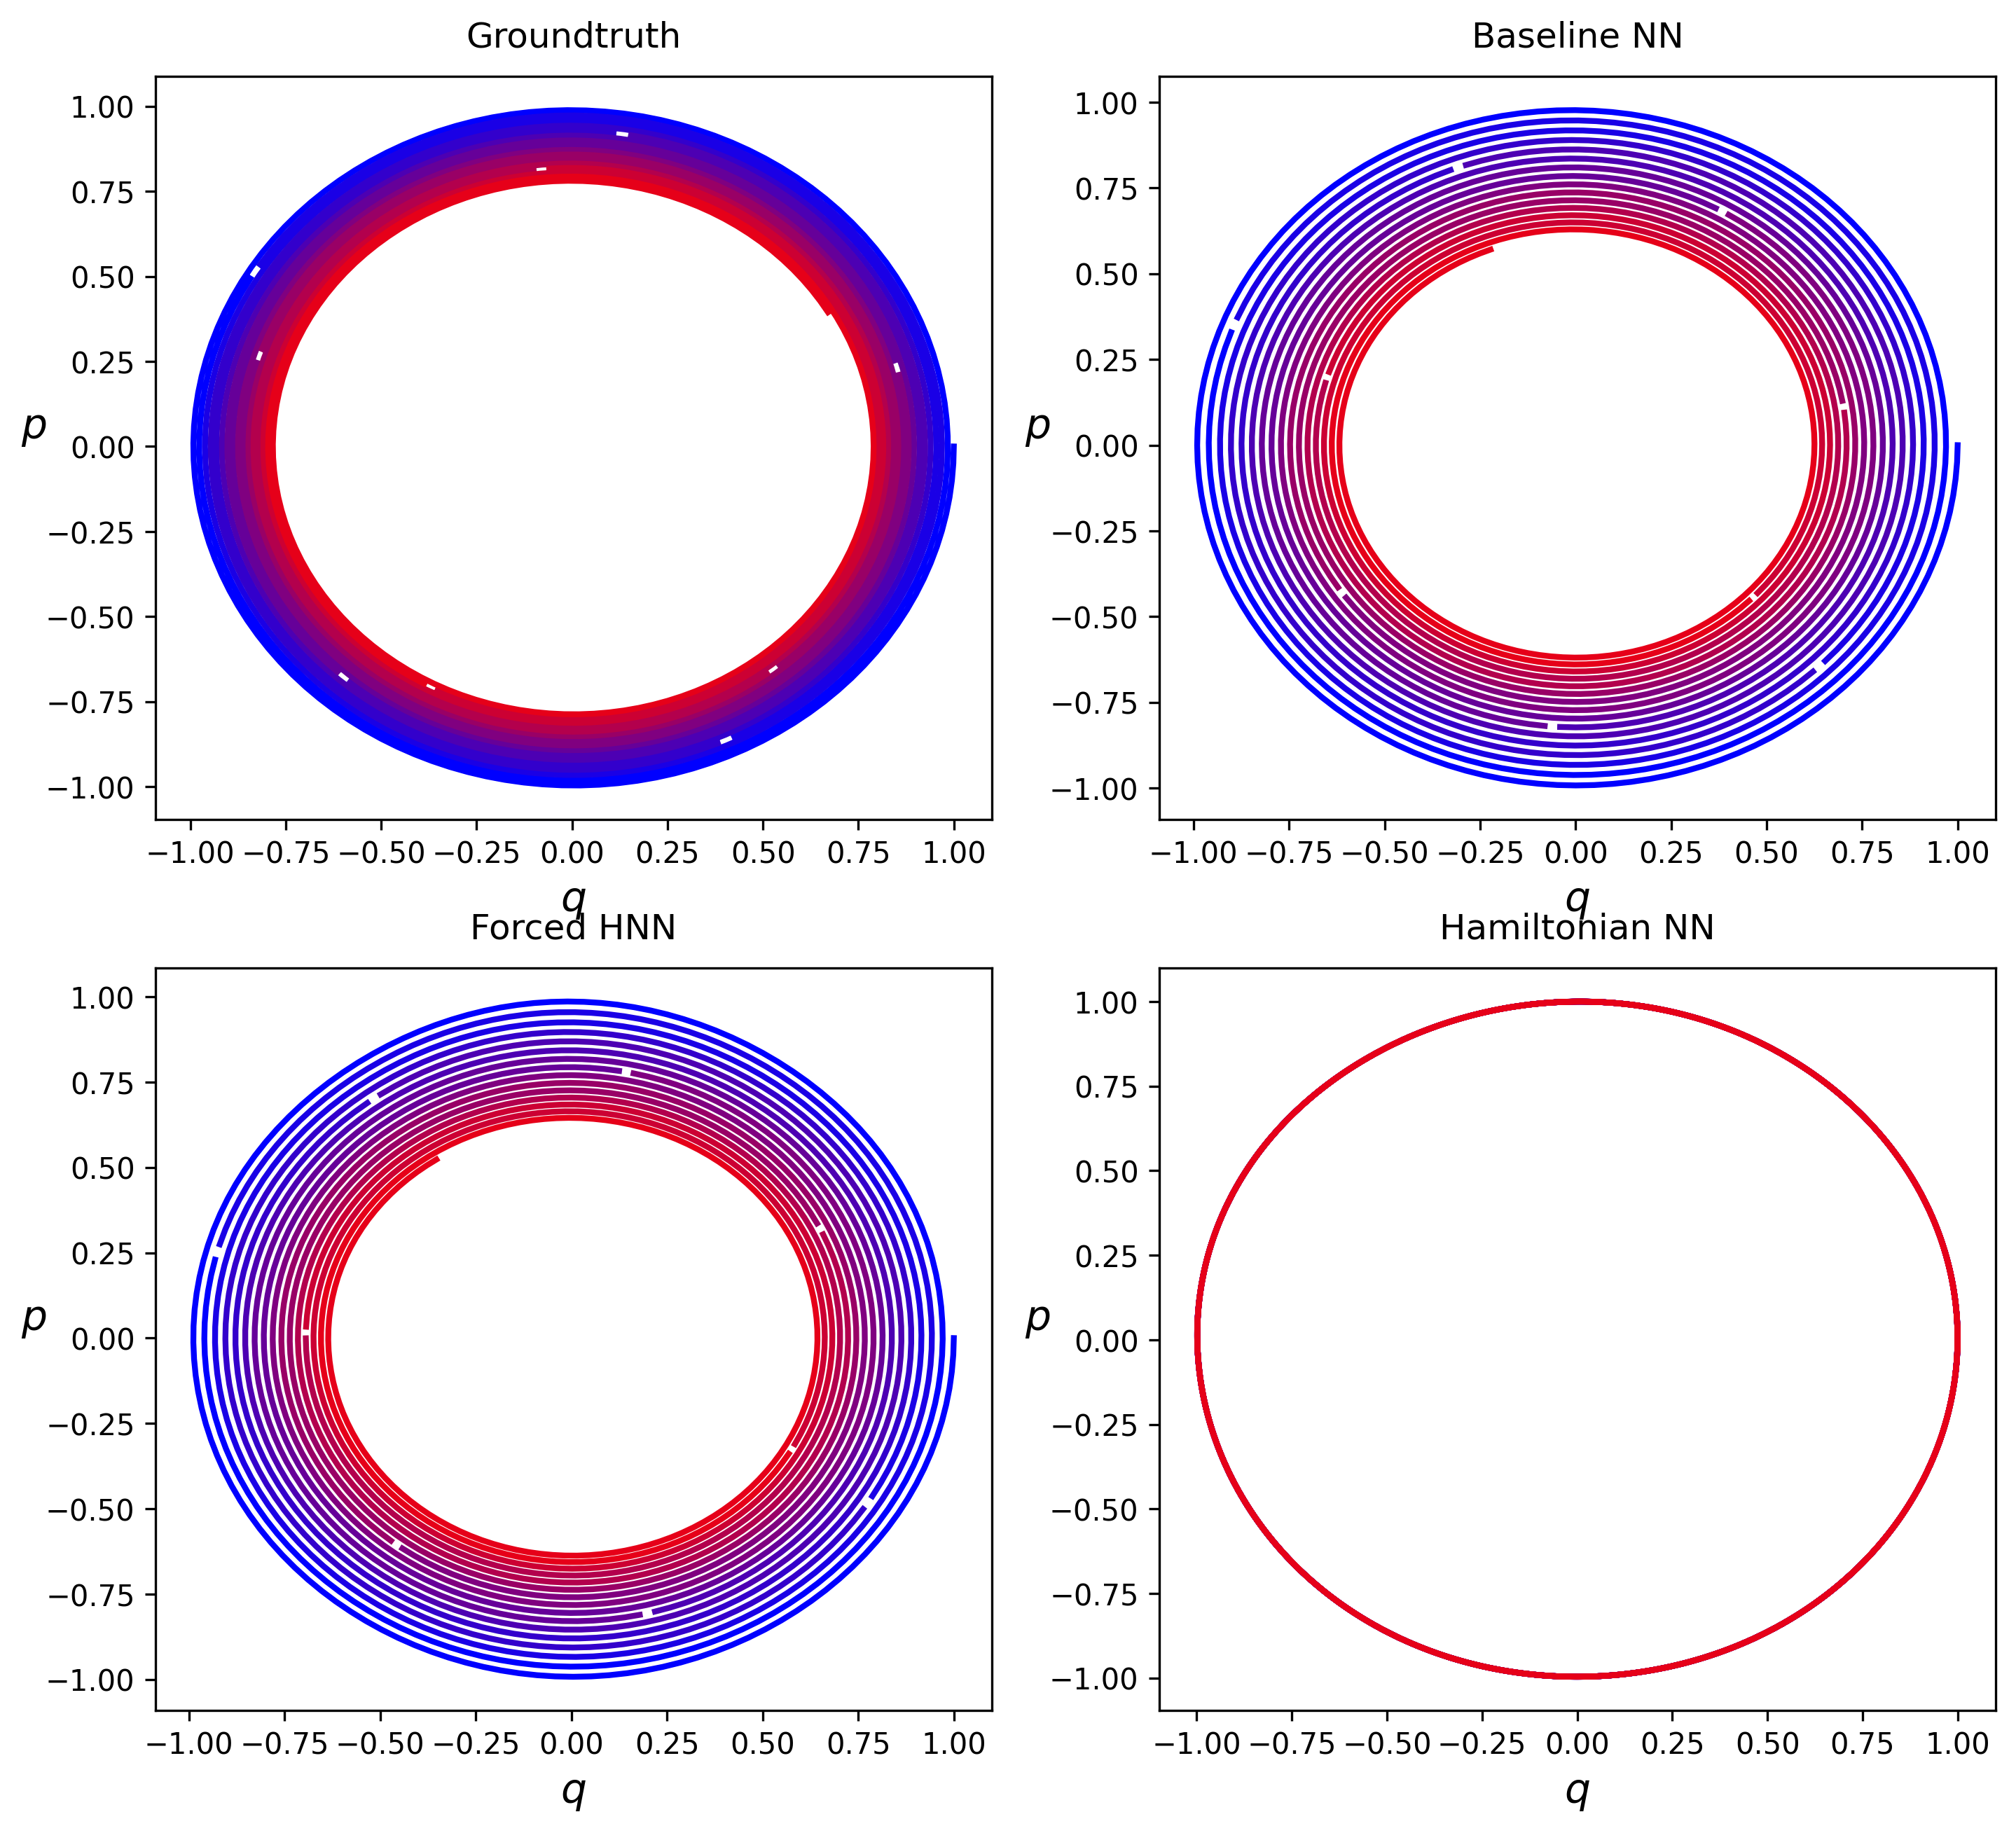

In [9]:
fig = plt.figure(figsize=(11.3, 10.1), facecolor='white', dpi=DPI)

#plot ground truth ext
fig.add_subplot(2, 2, 1, frameon=True)

for i, l in enumerate(np.split(integrate_true_ext['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Groundtruth", pad=10)

# plot baseline ext
fig.add_subplot(2, 2, 2, frameon=True)

for i, l in enumerate(np.split(integrate_model_bnn_ext['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot Forced HNN
fig.add_subplot(2, 2, 3, frameon=True)

for i, l in enumerate(np.split(integrate_model_forced_hnn['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Forced HNN", pad=10)

# plot HNN ext
fig.add_subplot(2, 2, 4, frameon=True)

for i, l in enumerate(np.split(integrate_model_hnn_ext['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

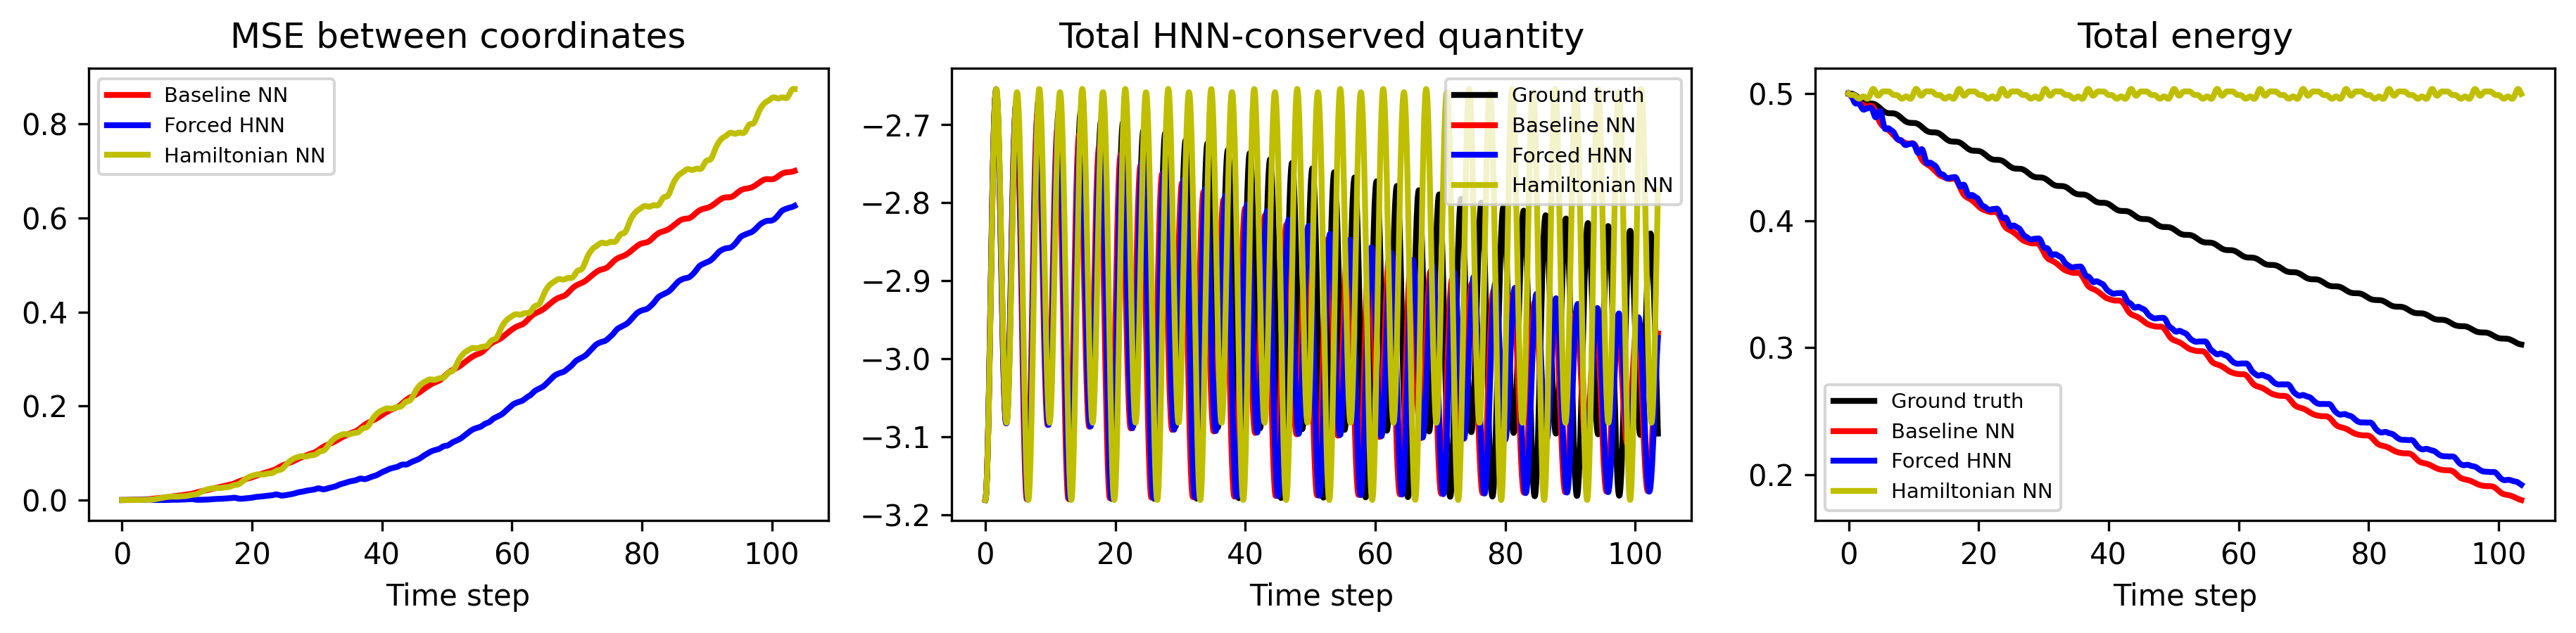

BNNによる予測エネルギーがep_nbdを外れる時間 0.046502499999999995
Forced HNNによる予測エネルギーがep_nbdを外れる時間 0.05434
HNNによる予測エネルギーがep_nbdを外れる時間 0.036052499999999994


In [10]:
fig = plt.figure(figsize=(12.3, 3.1), facecolor='white', dpi=DPI)
tpad =7
noise_std = 0.05   #ノイズの設定を忘れないこと
t_span = [0,100]
y0 = np.asarray([1, 0])
t_eval=np.linspace(t_span[0], t_span[1], 2000)

# integrate along ground truth vector field
true_path_ext = solve_ivp(fun=dynamics_fn_ext, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-12)
true_y_ext = true_path_ext['y'].T

# ノイズの影響を補正するために時間を再スケールする必要があることに注意
t_span[1] *= 1 + .7*noise_std
t_eval *= 1 + .7*noise_std

# integrate along baseline vector field
base_path_ext = integrate_model(model_bnn_ext, y0=y0, t_span=t_span, t_eval=t_eval, rtol=1e-12)
base_y_ext = base_path_ext['y'].T

# integrate along  Forced HNN vector field
forced_hnn_path = integrate_model(model_forced_hnn, y0=y0, t_span=t_span, t_eval=t_eval, baseline=False, rtol=1e-12)
forced_hnn_y = forced_hnn_path['y'].T

# integrate along HNN vector field
hnn_ext_path = integrate_model(model_hnn_ext, y0=y0, t_span=t_span, t_eval=t_eval, baseline=False, rtol=1e-12)
hnn_ext_y = hnn_ext_path['y'].T

plt.subplot(1,3,1)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_y_ext-base_y_ext)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_y_ext-forced_hnn_y)**2).mean(-1), 'b-', label='Forced HNN', linewidth=2)
plt.plot(t_eval, ((true_y_ext-hnn_ext_y)**2).mean(-1), 'y-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,3,2)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq_ext = model_forced_hnn.hnn_model(torch.Tensor(true_y_ext)).detach().numpy().squeeze()
base_hq_ext = model_forced_hnn.hnn_model(torch.Tensor(base_y_ext)).detach().numpy().squeeze()
forced_hnn_hq = model_forced_hnn.hnn_model(torch.Tensor(forced_hnn_y)).detach().numpy().squeeze()
hnn_ext_hq = model_forced_hnn.hnn_model(torch.Tensor(hnn_ext_y)).detach().numpy().squeeze()
plt.plot(t_eval, true_hq_ext, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq_ext, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, forced_hnn_hq, 'b-', label='Forced HNN', linewidth=2)
plt.plot(t_eval, hnn_ext_hq, 'y-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,3,3)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e_ext = np.stack([hamiltonian_fn(c) for c in true_y_ext])
base_e_ext = np.stack([hamiltonian_fn(c) for c in base_y_ext])
forced_hnn_e = np.stack([hamiltonian_fn(c) for c in forced_hnn_y])
hnn_ext_e = np.stack([hamiltonian_fn(c) for c in hnn_ext_y])
plt.plot(t_eval, true_e_ext, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e_ext, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, forced_hnn_e, 'b-', label='Forced HNN', linewidth=2)
plt.plot(t_eval, hnn_ext_e, 'y-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()

ep_nbd = 0.01
for num in range(0,2000):
    if abs(true_e_ext[num]-base_e_ext[num]) > ep_nbd:
        print("BNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/2000)
        break
    if num == 1999:
        print("BNNによる予測エネルギーはep_nbdを外れない")

for num in range(0,2000):
    if abs(true_e_ext[num]-forced_hnn_e[num]) > ep_nbd:
        print("Forced HNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/2000)
        break
    if num == 1999:
        print(" Forced HNNによる予測エネルギーはep_nbdを外れない")

for num in range(0,2000):
    if abs(true_e_ext[num]-hnn_ext_e[num]) > ep_nbd:
        print("HNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/2000)
        break
    if num == 1999:
        print(" HNNによる予測エネルギーはep_nbdを外れない")

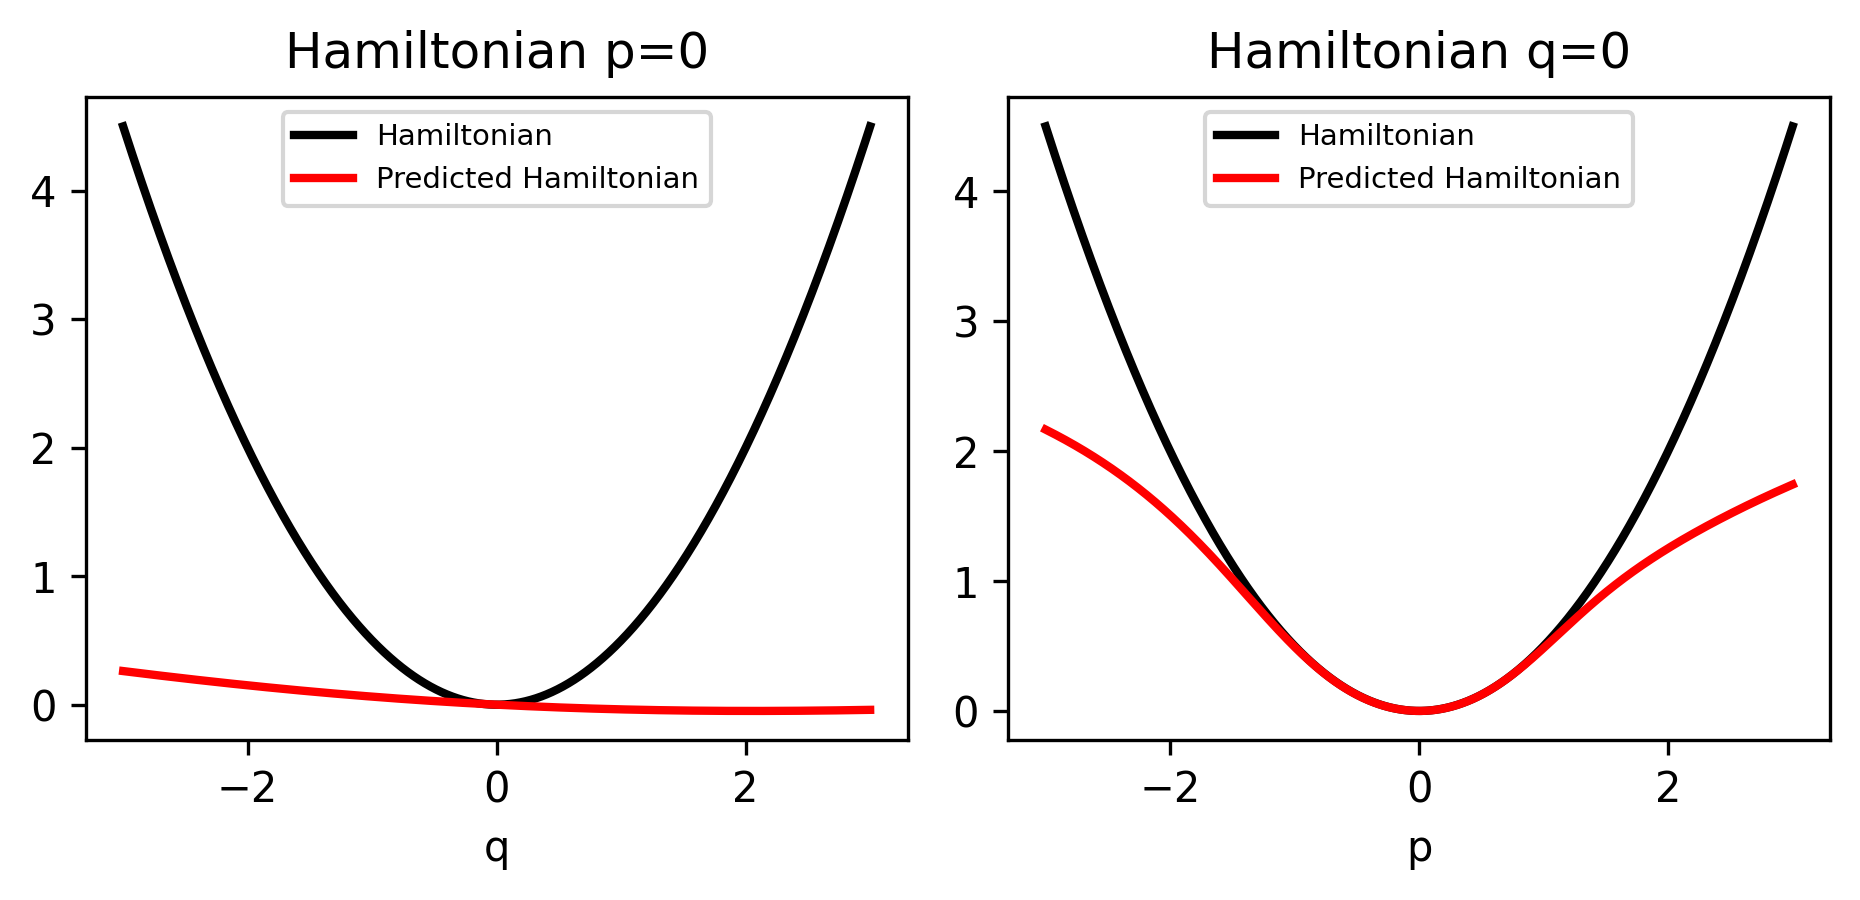

In [11]:
from numpy import linalg as LA
fig = plt.figure(figsize=(6.3, 3.1), facecolor='white', dpi=DPI)

#ハミルトニアンとHNNで予測されるハミルトニアンはある定数だけ異なるので補正する
plt.subplot(1,2,1)
plt.title("Hamiltonian p=0", pad=tpad) ; plt.xlabel('q')
p = 0
qs = np.linspace(-3, 3, 2000)
H_true =  np.stack([hamiltonian_fn(np.array([q,p])) for q in qs]).squeeze()
plt.plot(qs, H_true, 'k-', label='Hamiltonian', linewidth=2)
coords = np.stack([np.array([q,p]) for q in qs])
H_pred = model_forced_hnn.hnn_model(torch.Tensor(coords)).detach().numpy().squeeze()
corre = np.full(2000, H_true[1000]-H_pred[1000])
plt.plot(qs, H_pred+corre, 'r-', label='Predicted Hamiltonian', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,2,2)
plt.title("Hamiltonian q=0", pad=tpad) ; plt.xlabel('p')
q = 0
ps = np.linspace(-3, 3, 2000)
H_true =  np.stack([hamiltonian_fn(np.array([q,p])) for p in ps]).squeeze()
plt.plot(ps, H_true, 'k-', label='Hamiltonian', linewidth=2)
coords = np.stack([np.array([q,p]) for p in ps])
H_pred = model_forced_hnn.hnn_model(torch.Tensor(coords)).detach().numpy().squeeze()
corre = np.full(2000, H_true[1000] - H_pred[1000])
plt.plot(ps, H_pred + corre, 'r-', label='Predicted Hamiltonian', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()

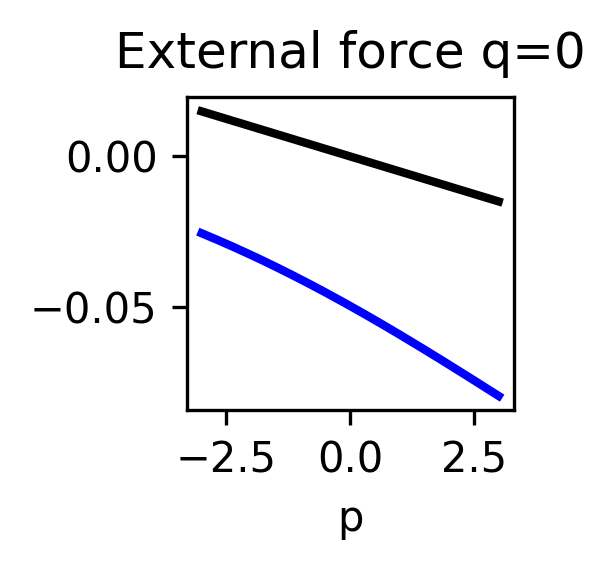

In [12]:
fig = plt.figure(figsize=(2, 2), facecolor='white', dpi=DPI)

plt.subplot(1,1,1)
plt.title("External force q=0", pad=tpad) ; plt.xlabel('p')
q = 0
ps = np.linspace(-3, 3, 2000)
ext_true =  np.stack([ext_f(np.array([q,p])) for p in ps]).squeeze()
plt.plot(ps, ext_true, 'k-', label='External force', linewidth=2)
coords = np.stack([np.array([q,p]) for p in ps])
ext_pred = model_forced_hnn(torch.Tensor(coords)).detach().numpy().squeeze()
plt.plot(ps, ext_pred, 'b-', label='Predicted External force', linewidth=2)
coord = np.stack([np.array([p]) for p in ps])

plt.tight_layout() ; plt.show()

In [13]:
data_ext = get_dataset(ext=True, noise_std=0.0)

In [14]:
model_bnn_ext, stats_bnn_ext = train(baseline=True, total_steps=2000, data=data_ext)
model_forced_hnn, stats_forced_hnn = train(baseline=False, total_steps=2000, data=data_ext, ext=True)
model_hnn_ext, stats_hnn_ext = train(baseline=False, data=data_ext, total_steps=2000)

Training baseline model:
step 0, train_loss 2.4852e-01, test_loss 3.7394e-01
step 200, train_loss 2.5211e-06, test_loss 3.6387e-06
step 400, train_loss 2.2584e-06, test_loss 3.1038e-06
step 600, train_loss 2.0846e-06, test_loss 2.7048e-06
step 800, train_loss 2.1323e-06, test_loss 2.8500e-06
step 1000, train_loss 1.2843e-04, test_loss 1.0983e-03
step 1200, train_loss 1.8285e-06, test_loss 2.0732e-06
step 1400, train_loss 3.4881e-04, test_loss 6.6964e-04
step 1600, train_loss 1.7370e-06, test_loss 1.9043e-06
step 1800, train_loss 1.6896e-06, test_loss 1.7395e-06
step 2000, train_loss 1.6618e-06, test_loss 1.7852e-06
Final train loss 1.6624e-06 +/- 9.6033e-08
Final test loss 1.7852e-06 +/- 1.4862e-07
Training  Forced HNN model:
step 0, train_loss 1.9512e-01, test_loss 4.0092e-01
step 200, train_loss 6.0594e-05, test_loss 1.3581e-04
step 400, train_loss 4.6346e-05, test_loss 1.0484e-04
step 600, train_loss 4.4174e-05, test_loss 9.9755e-05
step 800, train_loss 4.1144e-05, test_loss 9.5062e

In [15]:
integrate_true_ext = integrate(ext=True)
integrate_model_bnn_ext = integrate_model(model_bnn_ext)
integrate_model_forced_hnn = integrate_model(model_forced_hnn, baseline=False)
integrate_model_hnn_ext = integrate_model(model_hnn_ext, baseline=False)

Text(0.5, 1.0, 'Hamiltonian NN')

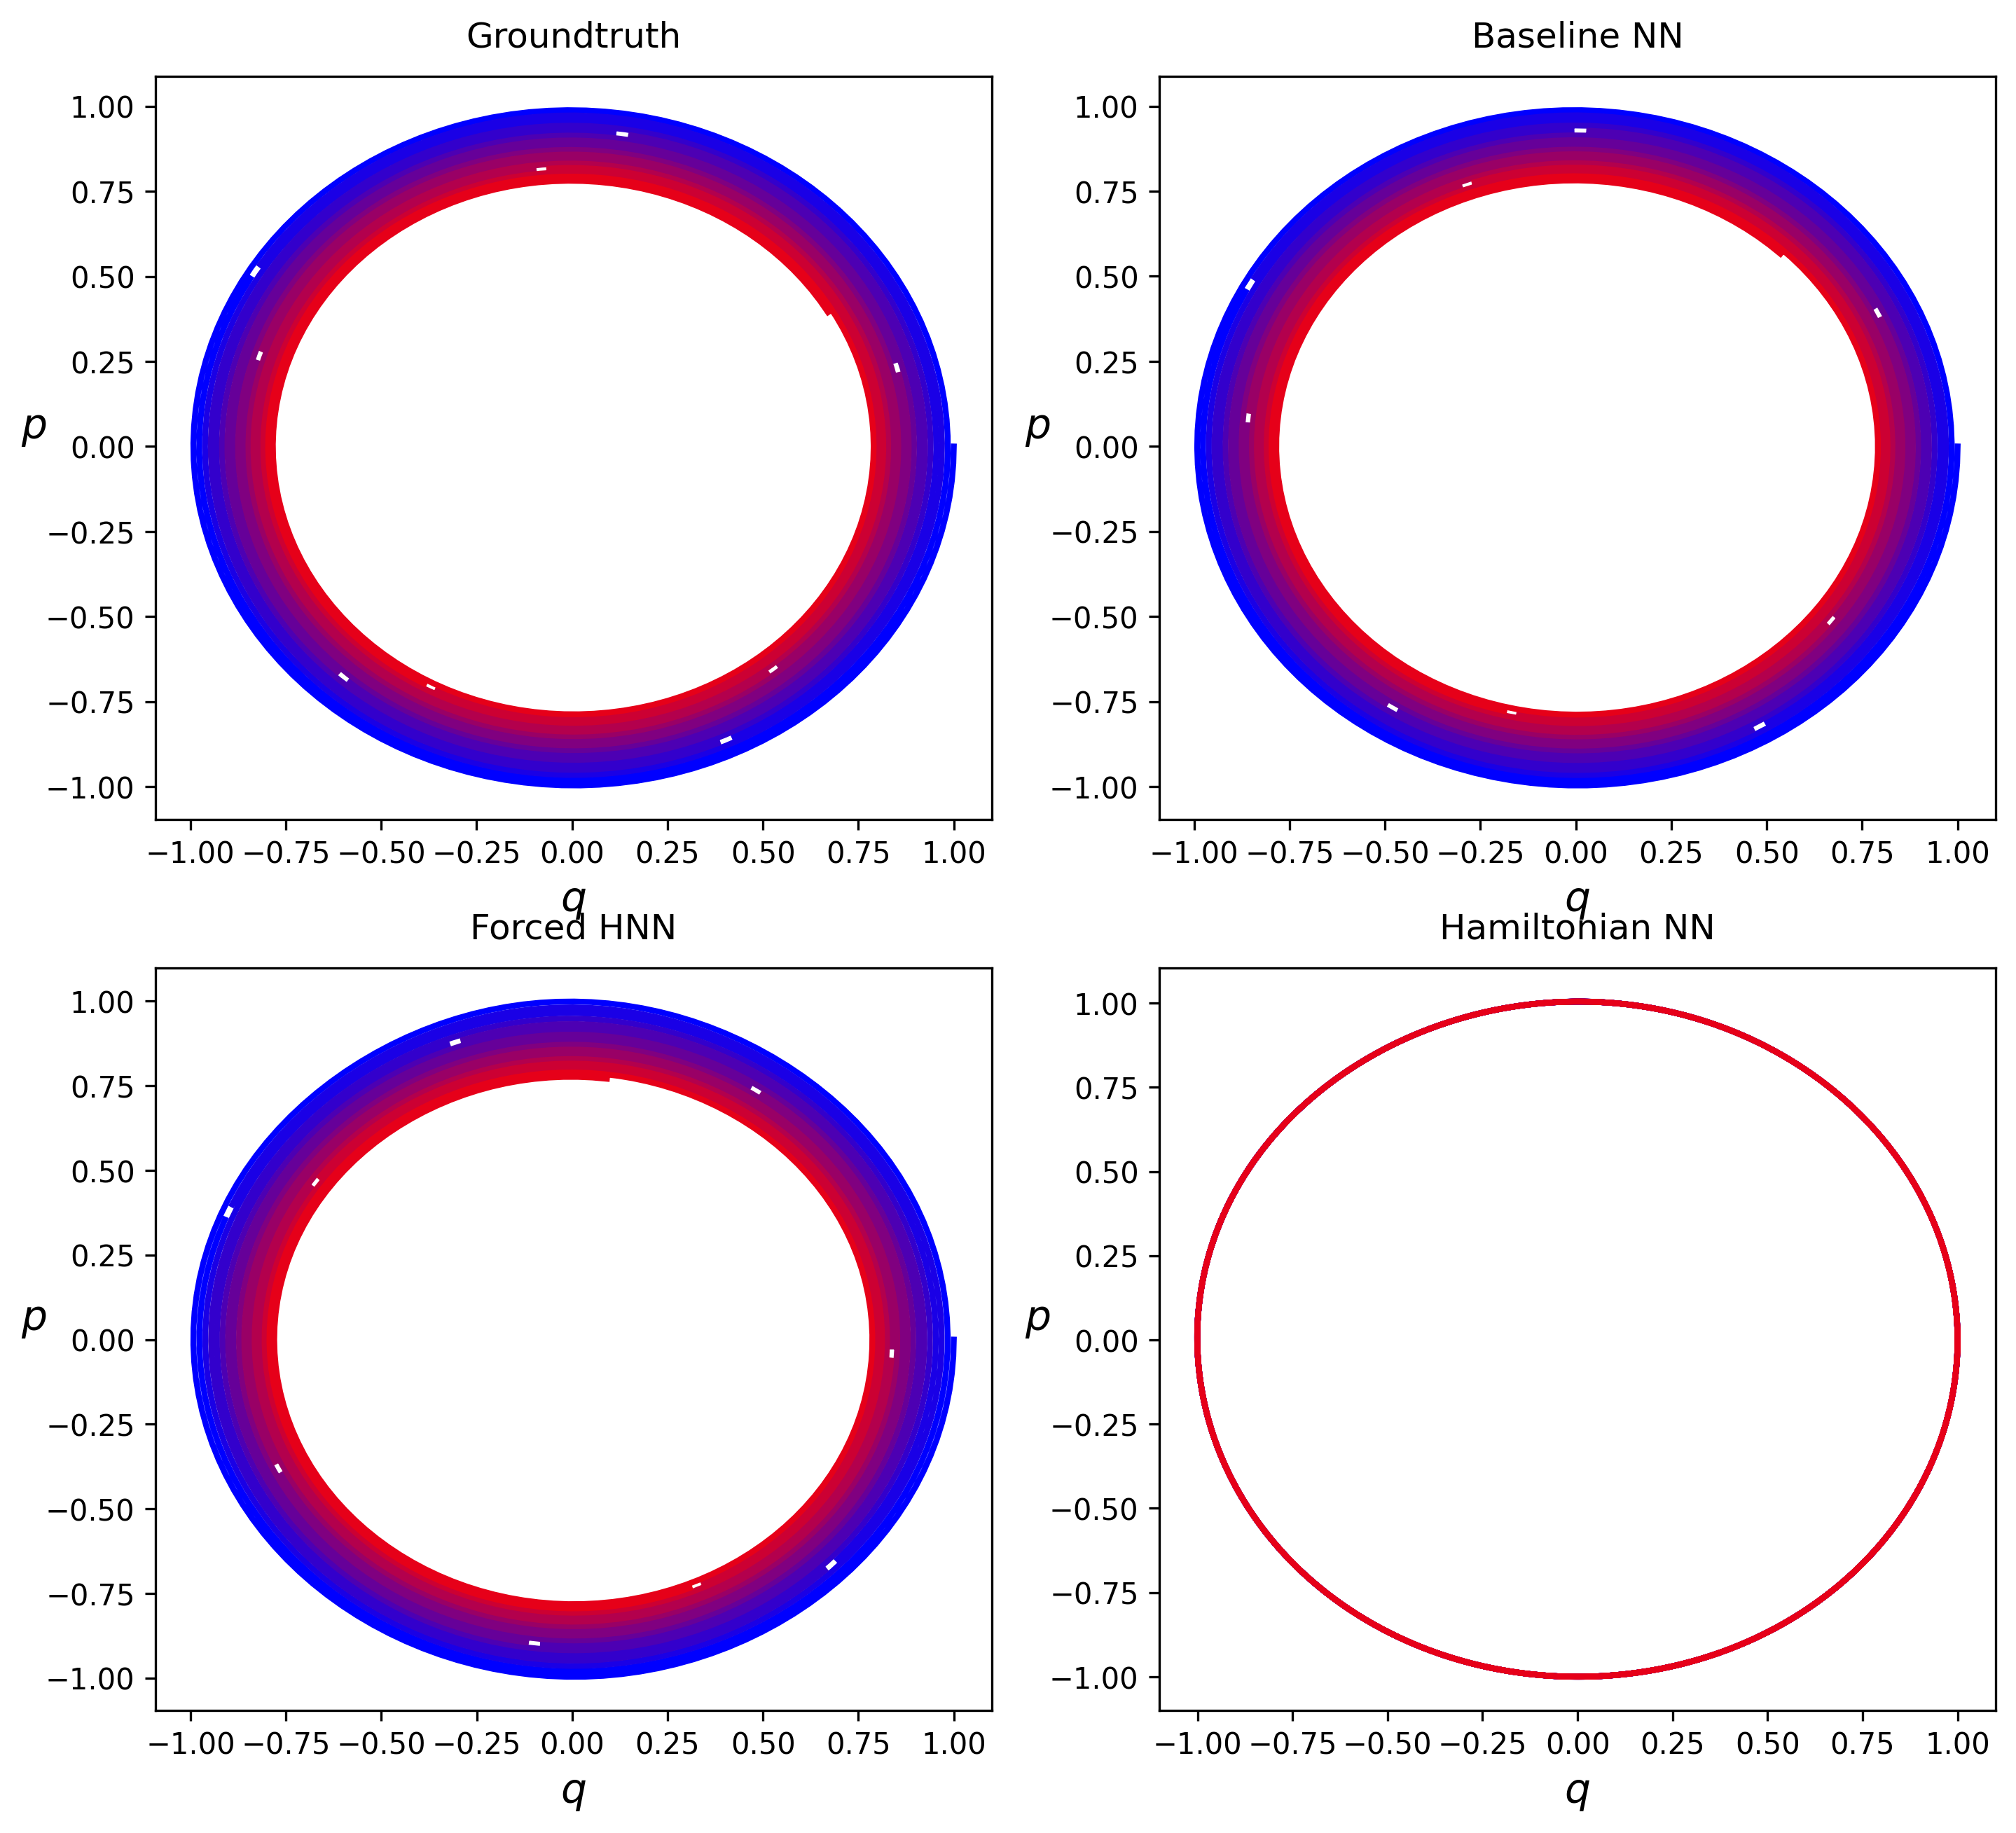

In [16]:
fig = plt.figure(figsize=(11.3, 10.1), facecolor='white', dpi=DPI)

#plot ground truth ext
fig.add_subplot(2, 2, 1, frameon=True)

for i, l in enumerate(np.split(integrate_true_ext['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Groundtruth", pad=10)

# plot baseline ext
fig.add_subplot(2, 2, 2, frameon=True)

for i, l in enumerate(np.split(integrate_model_bnn_ext['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot  Forced HNN
fig.add_subplot(2, 2, 3, frameon=True)

for i, l in enumerate(np.split(integrate_model_forced_hnn['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Forced HNN", pad=10)

# plot HNN ext
fig.add_subplot(2, 2, 4, frameon=True)

for i, l in enumerate(np.split(integrate_model_hnn_ext['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

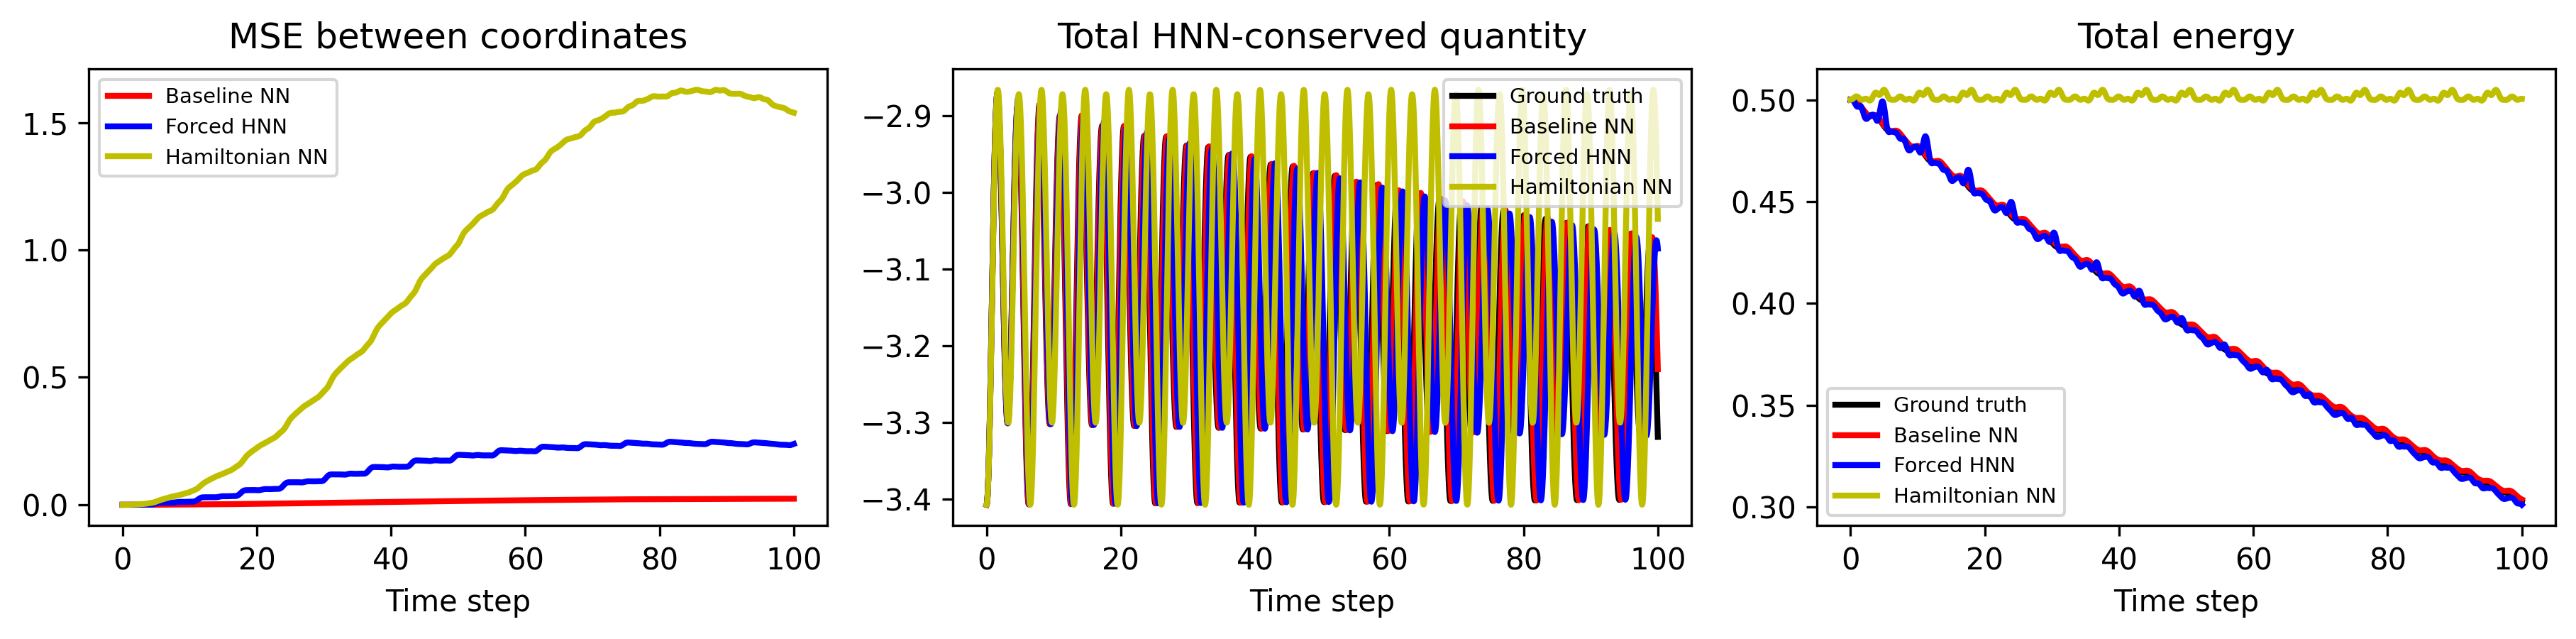

BNNによる予測エネルギーはep_nbdを外れない
Forced HNNによる予測エネルギーがep_nbdを外れる時間 0.0465
HNNによる予測エネルギーがep_nbdを外れる時間 0.0345


In [17]:
fig = plt.figure(figsize=(12.3, 3.1), facecolor='white', dpi=DPI)
tpad =7
noise_std = 0.0   #ノイズの設定を忘れないこと
t_span = [0,100]
y0 = np.asarray([1, 0])
t_eval=np.linspace(t_span[0], t_span[1], 2000)

# integrate along ground truth vector field
true_path_ext = solve_ivp(fun=dynamics_fn_ext, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-12)
true_y_ext = true_path_ext['y'].T

# ノイズの影響を補正するために時間を再スケールする必要があることに注意
t_span[1] *= 1 + .7*noise_std
t_eval *= 1 + .7*noise_std

# integrate along baseline vector field
base_path_ext = integrate_model(model_bnn_ext, y0=y0, t_span=t_span, t_eval=t_eval, rtol=1e-12)
base_y_ext = base_path_ext['y'].T

# integrate along  Forced HNN vector field
forced_hnn_path = integrate_model(model_forced_hnn, y0=y0, t_span=t_span, t_eval=t_eval, baseline=False, rtol=1e-12)
forced_hnn_y = forced_hnn_path['y'].T

# integrate along HNN vector field
hnn_ext_path = integrate_model(model_hnn_ext, y0=y0, t_span=t_span, t_eval=t_eval, baseline=False, rtol=1e-12)
hnn_ext_y = hnn_ext_path['y'].T

plt.subplot(1,3,1)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_y_ext-base_y_ext)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_y_ext-forced_hnn_y)**2).mean(-1), 'b-', label='Forced HNN', linewidth=2)
plt.plot(t_eval, ((true_y_ext-hnn_ext_y)**2).mean(-1), 'y-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,3,2)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq_ext = model_forced_hnn.hnn_model(torch.Tensor(true_y_ext)).detach().numpy().squeeze()
base_hq_ext = model_forced_hnn.hnn_model(torch.Tensor(base_y_ext)).detach().numpy().squeeze()
forced_hnn_hq = model_forced_hnn.hnn_model(torch.Tensor(forced_hnn_y)).detach().numpy().squeeze()
hnn_ext_hq = model_forced_hnn.hnn_model(torch.Tensor(hnn_ext_y)).detach().numpy().squeeze()
plt.plot(t_eval, true_hq_ext, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq_ext, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, forced_hnn_hq, 'b-', label='Forced HNN', linewidth=2)
plt.plot(t_eval, hnn_ext_hq, 'y-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,3,3)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e_ext = np.stack([hamiltonian_fn(c) for c in true_y_ext])
base_e_ext = np.stack([hamiltonian_fn(c) for c in base_y_ext])
forced_hnn_e = np.stack([hamiltonian_fn(c) for c in forced_hnn_y])
hnn_ext_e = np.stack([hamiltonian_fn(c) for c in hnn_ext_y])
plt.plot(t_eval, true_e_ext, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e_ext, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, forced_hnn_e, 'b-', label='Forced HNN', linewidth=2)
plt.plot(t_eval, hnn_ext_e, 'y-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()

ep_nbd = 0.01
for num in range(0,2000):
    if abs(true_e_ext[num]-base_e_ext[num]) > ep_nbd:
        print("BNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/2000)
        break
    if num == 1999:
        print("BNNによる予測エネルギーはep_nbdを外れない")

for num in range(0,2000):
    if abs(true_e_ext[num]-forced_hnn_e[num]) > ep_nbd:
        print("Forced HNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/2000)
        break
    if num == 1999:
        print(" Forced HNNによる予測エネルギーはep_nbdを外れない")

for num in range(0,2000):
    if abs(true_e_ext[num]-hnn_ext_e[num]) > ep_nbd:
        print("HNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/2000)
        break
    if num == 1999:
        print(" HNNによる予測エネルギーはep_nbdを外れない")

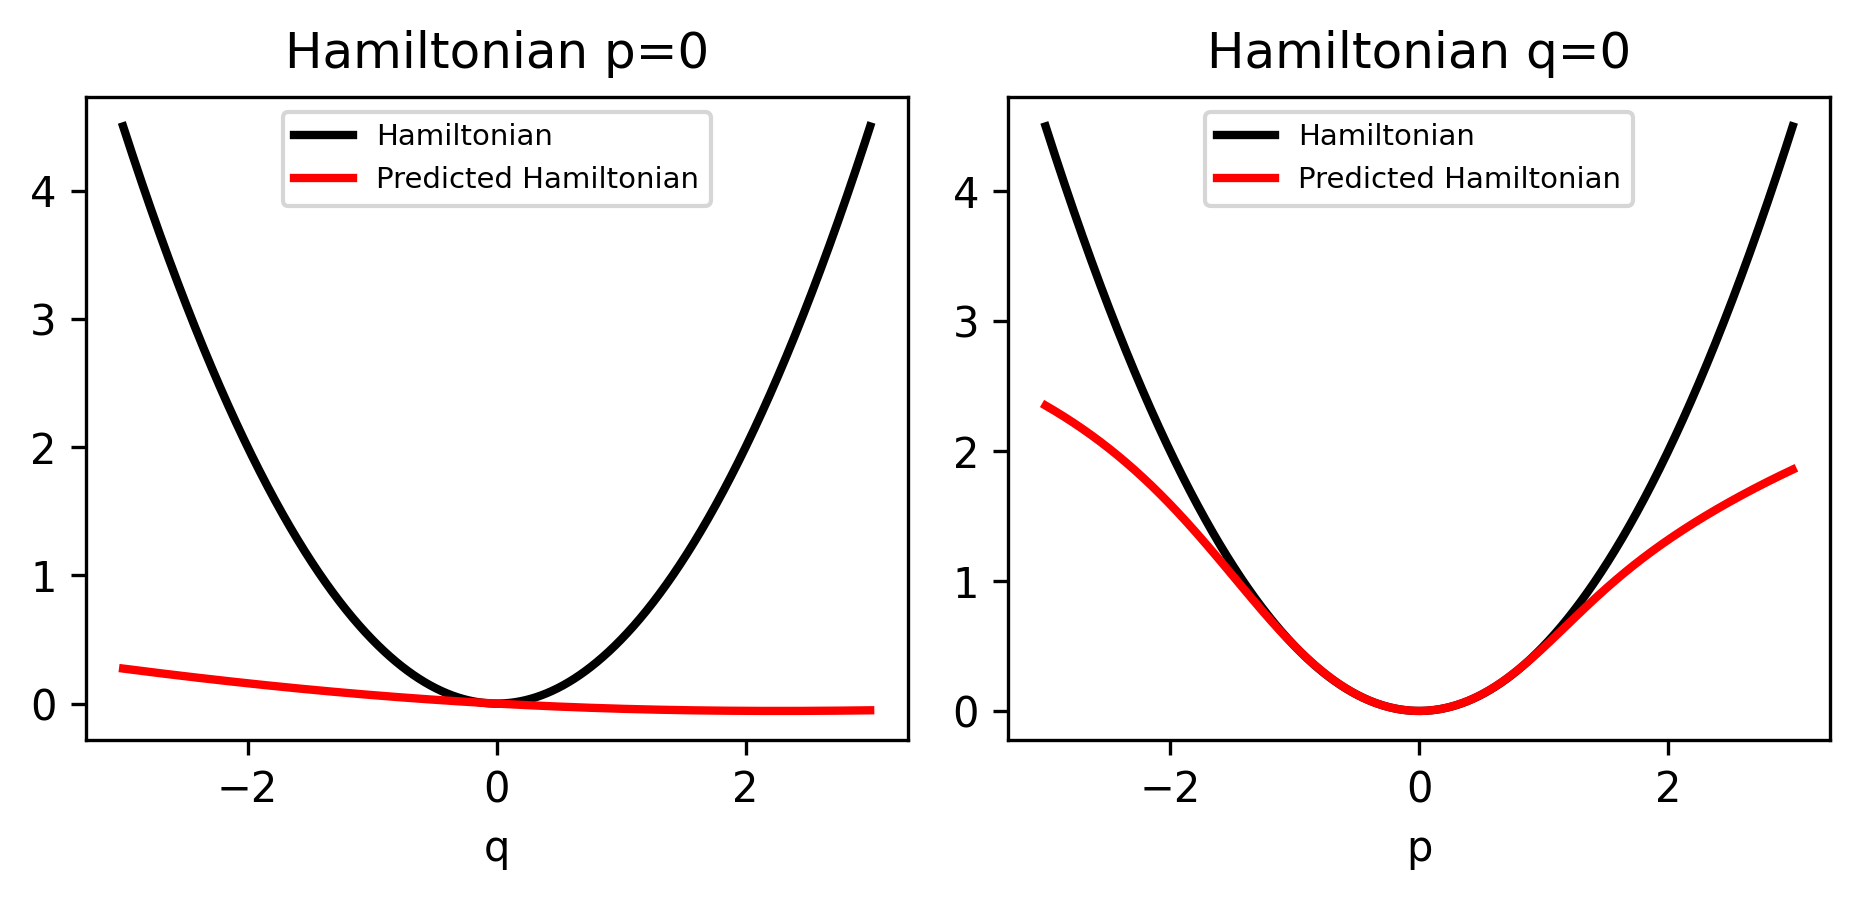

In [18]:
from numpy import linalg as LA
fig = plt.figure(figsize=(6.3, 3.1), facecolor='white', dpi=DPI)

#ハミルトニアンとHNNで予測されるハミルトニアンはある定数だけ異なるので補正する
plt.subplot(1,2,1)
plt.title("Hamiltonian p=0", pad=tpad) ; plt.xlabel('q')
p = 0
qs = np.linspace(-3, 3, 2000)
H_true =  np.stack([hamiltonian_fn(np.array([q,p])) for q in qs]).squeeze()
plt.plot(qs, H_true, 'k-', label='Hamiltonian', linewidth=2)
coords = np.stack([np.array([q,p]) for q in qs])
H_pred = model_forced_hnn.hnn_model(torch.Tensor(coords)).detach().numpy().squeeze()
corre = np.full(2000, H_true[1000]-H_pred[1000])
plt.plot(qs, H_pred+corre, 'r-', label='Predicted Hamiltonian', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,2,2)
plt.title("Hamiltonian q=0", pad=tpad) ; plt.xlabel('p')
q = 0
ps = np.linspace(-3, 3, 2000)
H_true =  np.stack([hamiltonian_fn(np.array([q,p])) for p in ps]).squeeze()
plt.plot(ps, H_true, 'k-', label='Hamiltonian', linewidth=2)
coords = np.stack([np.array([q,p]) for p in ps])
H_pred = model_forced_hnn.hnn_model(torch.Tensor(coords)).detach().numpy().squeeze()
corre = np.full(2000, H_true[1000] - H_pred[1000])
plt.plot(ps, H_pred + corre, 'r-', label='Predicted Hamiltonian', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()

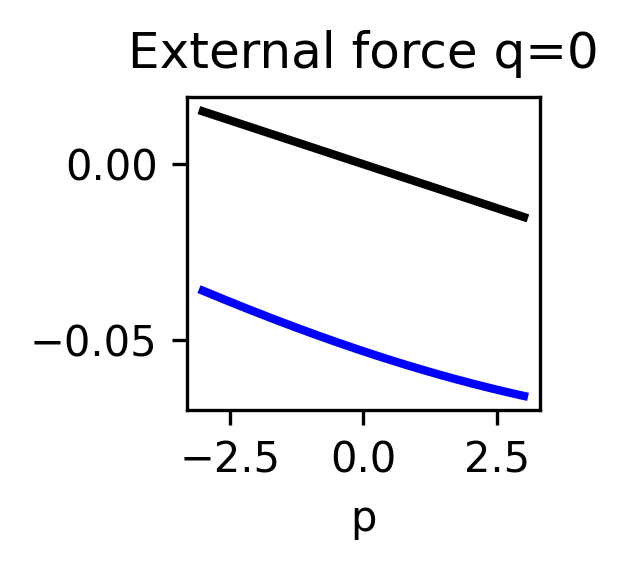

In [19]:
fig = plt.figure(figsize=(2, 2), facecolor='white', dpi=DPI)

plt.subplot(1,1,1)
plt.title("External force q=0", pad=tpad) ; plt.xlabel('p')
q = 0
ps = np.linspace(-3, 3, 2000)
ext_true =  np.stack([ext_f(np.array([q,p])) for p in ps]).squeeze()
plt.plot(ps, ext_true, 'k-', label='External force', linewidth=2)
coords = np.stack([np.array([q,p]) for p in ps])
ext_pred = model_forced_hnn(torch.Tensor(coords)).detach().numpy().squeeze()
plt.plot(ps, ext_pred, 'b-', label='Predicted External force', linewidth=2)
coord = np.stack([np.array([p]) for p in ps])

plt.tight_layout() ; plt.show()